In [17]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/pairs_trading_project")

DATA_DIR     = PROJECT_ROOT / "data"
PROC_DIR     = DATA_DIR / "processed"
RESULTS_DIR  = PROJECT_ROOT / "results"
STATS_DIR    = RESULTS_DIR / "statistics"
FIG_DIR      = RESULTS_DIR / "figures"
MODELS_DIR   = PROJECT_ROOT / "models"

for d in [PROC_DIR, STATS_DIR, FIG_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: /content/drive/MyDrive/pairs_trading_project


In [19]:
from pathlib import Path

patterns = [
    "ou_parameters*.csv",
    "ou_model_diagnostics*.csv",
    "regime_v2_*.csv",
    "regime_v3_*.csv",
    "regime_summary_v2*.csv",
    "regime_summary_v3*.csv",
    "regime_flags*.csv",
    "signal_quality*.csv",          # optional cleanup if you want Phase 5 clean too
]

deleted = []
for pat in patterns:
    for fp in STATS_DIR.glob(pat):
        fp.unlink()
        deleted.append(fp.name)

# figure(s)
for fp in FIG_DIR.glob("regime_overlay_spread*.png"):
    fp.unlink()
    deleted.append(fp.name)

# model rules
for fp in MODELS_DIR.glob("regime_rules*.json"):
    fp.unlink()
    deleted.append(fp.name)

print("Deleted files:", len(deleted))
deleted[:30]

Deleted files: 9


['ou_parameters.csv',
 'ou_model_diagnostics.csv',
 'regime_v2_FCX_GOLD.csv',
 'regime_v2_EOG_FANG.csv',
 'regime_v2_V_MA.csv',
 'regime_summary_v2.csv',
 'regime_flags.csv',
 'signal_quality_by_regime.csv',
 'regime_overlay_spread.png']

In [20]:
import pandas as pd
import numpy as np

prices_path = PROC_DIR / "prices_aligned.parquet"
prices = pd.read_parquet(prices_path)

# enforce datetime index
prices.index = pd.to_datetime(prices.index)
prices = prices.sort_index()

# choose your stable pairs (you currently have these 3)
PAIRS = [("EOG","FANG"), ("FCX","GOLD"), ("V","MA")]

ROLL_BETA = 252

def build_spread(prices: pd.DataFrame, a: str, b: str, roll=252) -> pd.Series:
    if a not in prices.columns or b not in prices.columns:
        raise KeyError(f"Missing columns for pair ({a},{b}). Have: {prices.columns.tolist()[:10]}...")

    x = np.log(prices[a]).rename(a)
    y = np.log(prices[b]).rename(b)

    # rolling regression y ~ alpha + beta x
    df = pd.concat([x, y], axis=1).dropna()
    xw = df[a]
    yw = df[b]

    beta = yw.rolling(roll).cov(xw) / xw.rolling(roll).var()
    alpha = yw.rolling(roll).mean() - beta * xw.rolling(roll).mean()

    spread = (yw - (alpha + beta * xw)).rename(f"{a}_{b}")
    return spread

spreads = {}
for a,b in PAIRS:
    key = f"{a}_{b}"
    spreads[key] = build_spread(prices, a, b, roll=ROLL_BETA)

list(spreads.keys()), spreads[list(spreads.keys())[0]].dropna().head()

(['EOG_FANG', 'FCX_GOLD', 'V_MA'],
 2016-12-30   -0.041899
 2017-01-03   -0.042804
 2017-01-04   -0.039417
 2017-01-05   -0.042270
 2017-01-06   -0.050005
 Name: EOG_FANG, dtype: float64)

In [21]:
import numpy as np
import pandas as pd

def fit_ou_ar1(x: pd.Series) -> dict:
    x = x.dropna()
    if len(x) < 200:
        return {"theta": np.nan, "mu": np.nan, "sigma": np.nan, "half_life_days": np.nan, "n_obs": len(x)}

    x0 = x.iloc[:-1].values
    x1 = x.iloc[1:].values

    X = np.column_stack([np.ones_like(x0), x0])
    beta, *_ = np.linalg.lstsq(X, x1, rcond=None)
    a, b = float(beta[0]), float(beta[1])

    # stationarity
    if not (0 < b < 1):
        return {"theta": np.nan, "mu": np.nan, "sigma": np.nan, "half_life_days": np.nan, "n_obs": len(x)}

    resid = x1 - (a + b * x0)
    resid_std = float(np.std(resid, ddof=1))

    theta = float(-np.log(b))
    mu = float(a / (1 - b))
    half_life = float(np.log(2) / theta)

    return {"theta": theta, "mu": mu, "sigma": resid_std, "half_life_days": half_life, "n_obs": len(x)}

rows = []
for pair, s in spreads.items():
    ou = fit_ou_ar1(s)
    rows.append({"pair": pair, **ou})

ou_params = pd.DataFrame(rows).sort_values("half_life_days")
ou_path = STATS_DIR / "ou_parameters.csv"
ou_params.to_csv(ou_path, index=False)

print("Saved:", ou_path)
ou_params

Saved: /content/drive/MyDrive/pairs_trading_project/results/statistics/ou_parameters.csv


,pair,theta,mu,sigma,half_life_days,n_obs
2,V_MA,0.049269,0.001536,0.008001,14.068519,2297
0,EOG_FANG,0.024105,0.007216,0.019587,28.755762,2297
1,FCX_GOLD,0.011035,0.027155,0.030903,62.812064,2297


In [22]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

diag_rows = []
for pair, s in spreads.items():
    x = s.dropna()
    if len(x) < 200:
        continue

    # AR(1) residuals
    x0 = x.iloc[:-1].values
    x1 = x.iloc[1:].values
    X = sm.add_constant(x0)
    m = sm.OLS(x1, X).fit()
    resid = x1 - m.predict(X)

    lb10 = acorr_ljungbox(resid, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    lb20 = acorr_ljungbox(resid, lags=[20], return_df=True)["lb_pvalue"].iloc[0]
    acf_vals = sm.tsa.stattools.acf(resid, nlags=5, fft=True)

    diag_rows.append({
        "pair": pair,
        "lb_pvalue_lag10": float(lb10),
        "lb_pvalue_lag20": float(lb20),
        "acf1": float(acf_vals[1]),
        "acf2": float(acf_vals[2]),
        "acf3": float(acf_vals[3]),
        "acf4": float(acf_vals[4]),
        "acf5": float(acf_vals[5]),
        "n_obs": int(len(x)),
    })

diag = pd.DataFrame(diag_rows)
diag_path = STATS_DIR / "ou_model_diagnostics.csv"
diag.to_csv(diag_path, index=False)

print("Saved:", diag_path)
diag

Saved: /content/drive/MyDrive/pairs_trading_project/results/statistics/ou_model_diagnostics.csv


,pair,lb_pvalue_lag10,lb_pvalue_lag20,acf1,acf2,acf3,acf4,acf5,n_obs
0,EOG_FANG,0.000007,0.000037,0.027407,0.013982,-0.067342,-0.092565,0.031445,2297
1,FCX_GOLD,0.054643,0.260353,-0.012737,0.029033,0.051938,-0.002500,0.030144,2297
2,V_MA,0.003864,0.003860,-0.057672,-0.042562,0.000922,0.012852,0.065663,2297


In [23]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import json

REG_WINDOW = 252
HL_MIN, HL_MAX = 5, 60
MIN_CROSSINGS = 8
ADF_WINDOW = 252
ADF_P_CUTOFF = 0.05

def rolling_half_life(series: pd.Series, window=252):
    hl = pd.Series(index=series.index, dtype=float)
    x = series.dropna()
    for i in range(window, len(x)):
        w = x.iloc[i-window:i]
        x0 = w.iloc[:-1].values
        x1 = w.iloc[1:].values
        X = sm.add_constant(x0)
        m = sm.OLS(x1, X).fit()
        b = m.params[1]
        if b <= 0 or b >= 1:
            hl.loc[w.index[-1]] = np.nan
        else:
            theta = -np.log(b)
            hl.loc[w.index[-1]] = np.log(2) / theta
    return hl

def mean_crossings_last_window(series: pd.Series, window=252):
    out = pd.Series(index=series.index, dtype=float)
    x = series.dropna()
    for i in range(window, len(x)):
        w = x.iloc[i-window:i]
        m = w.mean()
        signs = np.sign(w - m)
        crosses = int(np.sum((signs.shift(1) * signs) < 0))
        out.loc[w.index[-1]] = crosses
    return out

def rolling_adf_pvalue(series: pd.Series, window=252):
    out = pd.Series(index=series.index, dtype=float)
    x = series.dropna()
    for i in range(window, len(x)):
        w = x.iloc[i-window:i]
        try:
            p = adfuller(w.values, autolag="AIC")[1]
        except Exception:
            p = np.nan
        out.loc[w.index[-1]] = p
    return out

regime_outputs_v3 = {}
summary_rows = []
flags_rows = []

for pair, s in spreads.items():
    hl = rolling_half_life(s, window=REG_WINDOW)
    crosses = mean_crossings_last_window(s, window=REG_WINDOW)
    pvals = rolling_adf_pvalue(s, window=ADF_WINDOW)

    mr_v2 = ((hl >= HL_MIN) & (hl <= HL_MAX) & (crosses >= MIN_CROSSINGS)).astype(int)
    mr_adf = (pvals <= ADF_P_CUTOFF).astype(int)
    mr_final = ((mr_v2 == 1) & (mr_adf == 1)).astype(int)

    df = pd.DataFrame({
        "spread": s,
        "half_life_roll": hl,
        "mean_crossings_roll": crosses,
        "adf_p_roll": pvals,
        "mr_regime_v2": mr_v2,
        "mr_regime_adf": mr_adf,
        "mr_regime_final": mr_final
    })

    out_path = STATS_DIR / f"regime_v3_{pair}.csv"
    df.to_csv(out_path, index=True)
    regime_outputs_v3[pair] = df

    # long flags (final regime)
    tmp = df[["mr_regime_final"]].copy()
    tmp["pair"] = pair
    tmp = tmp.rename(columns={"mr_regime_final": "mr_regime"})
    tmp = tmp.reset_index().rename(columns={"index": "date"})
    flags_rows.append(tmp)

    summary_rows.append({
        "pair": pair,
        "mr_fraction_final": float(df["mr_regime_final"].mean()),
        "mr_fraction_v2": float(df["mr_regime_v2"].mean()),
        "mr_fraction_adf": float(df["mr_regime_adf"].mean()),
        "median_half_life_roll": float(df["half_life_roll"].median()),
        "median_crossings_roll": float(df["mean_crossings_roll"].median()),
        "median_adf_p_roll": float(df["adf_p_roll"].median()),
    })

    print(f"{pair}: MR% final={df['mr_regime_final'].mean():.2%} | saved {out_path.name}")

regime_summary = pd.DataFrame(summary_rows).sort_values("mr_fraction_final", ascending=False)
summary_path = STATS_DIR / "regime_summary_v3.csv"
regime_summary.to_csv(summary_path, index=False)

regime_flags = pd.concat(flags_rows, ignore_index=True).sort_values(["pair","date"])
flags_path = STATS_DIR / "regime_flags.csv"
regime_flags.to_csv(flags_path, index=False)

rules = {
    "version": "v3",
    "reg_window": REG_WINDOW,
    "hl_min": HL_MIN,
    "hl_max": HL_MAX,
    "min_crossings": MIN_CROSSINGS,
    "adf_window": ADF_WINDOW,
    "adf_p_cutoff": ADF_P_CUTOFF,
    "definition": "mr_final = (hl/crossings gate) AND (rolling ADF p <= cutoff)",
}
rules_path = MODELS_DIR / "regime_rules.json"
with open(rules_path, "w") as f:
    json.dump(rules, f, indent=2)

print("Saved:", summary_path)
print("Saved:", flags_path)
print("Saved:", rules_path)

regime_summary

EOG_FANG: MR% final=14.56% | saved regime_v3_EOG_FANG.csv
FCX_GOLD: MR% final=8.95% | saved regime_v3_FCX_GOLD.csv
V_MA: MR% final=12.99% | saved regime_v3_V_MA.csv
Saved: /content/drive/MyDrive/pairs_trading_project/results/statistics/regime_summary_v3.csv
Saved: /content/drive/MyDrive/pairs_trading_project/results/statistics/regime_flags.csv
Saved: /content/drive/MyDrive/pairs_trading_project/models/regime_rules.json


,pair,mr_fraction_final,mr_fraction_v2,mr_fraction_adf,median_half_life_roll,median_crossings_roll,median_adf_p_roll
0,EOG_FANG,0.145604,0.645604,0.146389,17.898168,18.0,0.208333
2,V_MA,0.129906,0.746860,0.141680,12.707184,20.0,0.133212
1,FCX_GOLD,0.089482,0.540031,0.089482,26.255309,16.0,0.254778


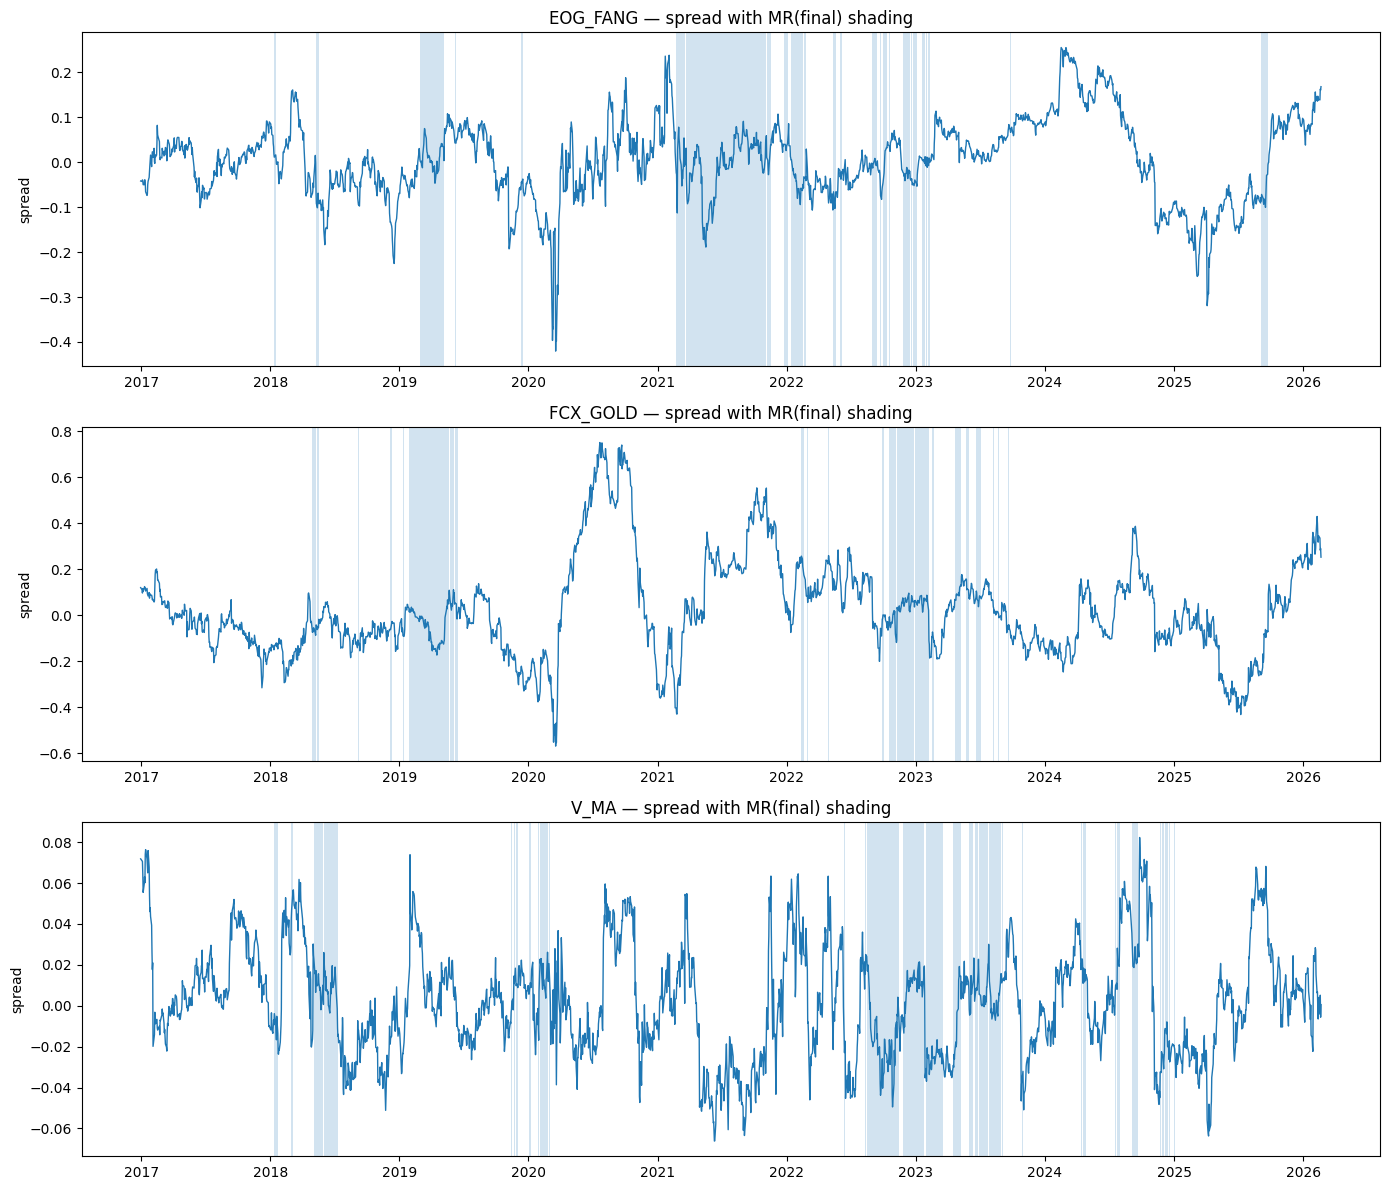

Saved: /content/drive/MyDrive/pairs_trading_project/results/figures/regime_overlay_spread.png


In [24]:
import matplotlib.pyplot as plt

pairs = list(regime_outputs_v3.keys())
plt.figure(figsize=(14, 4*len(pairs)))

for i, pair in enumerate(pairs, 1):
    df = regime_outputs_v3[pair]
    ax = plt.subplot(len(pairs), 1, i)
    ax.plot(df.index, df["spread"], linewidth=1)

    mr = df["mr_regime_final"].fillna(0).astype(int).values
    idx = df.index

    in_seg = False
    start = None
    for t in range(len(mr)):
        if mr[t] == 1 and not in_seg:
            in_seg = True
            start = idx[t]
        if in_seg and ((mr[t] == 0) or (t == len(mr)-1)):
            ax.axvspan(start, idx[t], alpha=0.2)
            in_seg = False

    ax.set_title(f"{pair} — spread with MR(final) shading")
    ax.set_ylabel("spread")

plt.tight_layout()
fig_path = FIG_DIR / "regime_overlay_spread.png"
plt.savefig(fig_path, dpi=200)
plt.show()
print("Saved:", fig_path)